# Import necessarry libraires

In [ ]:
!pip -q install gradio==4.44.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 78.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.2/131.2 kB 7.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-spark-connect 0.8.3 requires websockets>=14.0, but you have websockets 12.0 which is incompatible.
yfinance 0.2.65 requires websockets>=13.0, but you have websockets 12.0 which is incompatible.
google-genai 1.31.0 requires websockets<15.1.0,>=13.0.0, but you have websockets 12.0 which is incompatible.
google-adk 1.12.0 requires websockets<16.0.0,>=15.0.1, but you have websockets 12.0 which is incompatible.


In [ ]:
import os, io, json, joblib, random, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as w
from IPython.display import display, HTML
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.utils import shuffle

import gradio as gr

Keeping the seed value 42

In [ ]:
warnings.filterwarnings("ignore")
SEED = 42
np.random.seed(SEED); random.seed(SEED)

In [ ]:
# # Option B: Load from Drive (uncomment to use)
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/Symptom2Disease.csv', encoding='utf-8')

# Basic sanity checks
assert {'label','text'}.issubset(df.columns), "CSV must have 'label' and 'text' columns."
df = df[['label','text']].dropna().reset_index(drop=True)
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,label,text
0,Psoriasis,I have been experiencing a skin rash on my arm...
1,Psoriasis,"My skin has been peeling, especially on my kne..."
2,Psoriasis,I have been experiencing joint pain in my fing...
3,Psoriasis,"There is a silver like dusting on my skin, esp..."
4,Psoriasis,"My nails have small dents or pits in them, and..."


In [ ]:
print("Total rows:", len(df))
print("Unique diseases:", df['label'].nunique())
print(df['label'].value_counts().sort_index())

# (Optional) show a few samples
df.sample(5, random_state=SEED)


Total rows: 1200
Unique diseases: 24
label
Acne                               50
Arthritis                          50
Bronchial Asthma                   50
Cervical spondylosis               50
Chicken pox                        50
Common Cold                        50
Dengue                             50
Dimorphic Hemorrhoids              50
Fungal infection                   50
Hypertension                       50
Impetigo                           50
Jaundice                           50
Malaria                            50
Migraine                           50
Pneumonia                          50
Psoriasis                          50
Typhoid                            50
Varicose Veins                     50
allergy                            50
diabetes                           50
drug reaction                      50
gastroesophageal reflux disease    50
peptic ulcer disease               50
urinary tract infection            50
Name: count, dtype: int64


,label,text
1178,diabetes,"I have respiratory issues, especially when doi..."
865,Malaria,"I have a high fever, chills, and severe itchin..."
101,Typhoid,"I've also had some diarrhea, which has been re..."
439,Pneumonia,"I've recently been suffering with chills, leth..."
58,Varicose Veins,The swelling in my legs has gotten worse over ...


In [ ]:
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=SEED, stratify=df['label'])
val_df, test_df   = train_test_split(temp_df, test_size=0.5, random_state=SEED, stratify=temp_df['label'])

for name, d in [('Train',train_df),('Val',val_df),('Test',test_df)]:
    print(f"{name}: {len(d)} rows, {d['label'].nunique()} classes")

X_train, y_train = train_df['text'].values, train_df['label'].values
X_val,   y_val   = val_df['text'].values,   val_df['label'].values
X_test,  y_test  = test_df['text'].values,  test_df['label'].values


Train: 960 rows, 24 classes
Val: 120 rows, 24 classes
Test: 120 rows, 24 classes


# Logistic regression

In [ ]:
pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        analyzer="word",
        ngram_range=(1,2),          # unigrams + bigrams
        min_df=2,                   # ignore ultra-rare tokens
        max_df=0.9,                 # ignore super-common tokens
        sublinear_tf=True
    )),
    ("clf", LogisticRegression(
        max_iter=2000,
        multi_class="multinomial",
        n_jobs=-1 if hasattr(LogisticRegression, 'n_jobs') else None,
        random_state=SEED
    ))
])

param_grid = {
    "clf__C": [0.5, 1.0, 2.0, 5.0],
    "tfidf__ngram_range": [(1,1),(1,2)]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

grid = GridSearchCV(
    pipe,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=0
)

grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
print("Best CV macro-F1:", grid.best_score_)
best_clf = grid.best_estimator_


Best params: {'clf__C': 5.0, 'tfidf__ngram_range': (1, 2)}
Best CV macro-F1: 0.9716970121381886


Validation & test

In [ ]:
def evaluate(split_name, model, X, y):
    pred = model.predict(X)
    proba = model.predict_proba(X)
    acc  = accuracy_score(y, pred)
    f1m  = f1_score(y, pred, average='macro')
    print(f"\n[{split_name}]  Accuracy: {acc:.4f} | Macro-F1: {f1m:.4f}\n")
    print(classification_report(y, pred))
    return pred, proba

_ = evaluate("Validation", best_clf, X_val, y_val)
y_pred_test, _ = evaluate("Test", best_clf, X_test, y_test)



[Validation]  Accuracy: 0.9750 | Macro-F1: 0.9749

                                 precision    recall  f1-score   support

                           Acne       1.00      1.00      1.00         5
                      Arthritis       1.00      1.00      1.00         5
               Bronchial Asthma       1.00      1.00      1.00         5
           Cervical spondylosis       1.00      1.00      1.00         5
                    Chicken pox       0.80      0.80      0.80         5
                    Common Cold       1.00      1.00      1.00         5
                         Dengue       0.80      0.80      0.80         5
          Dimorphic Hemorrhoids       1.00      1.00      1.00         5
               Fungal infection       1.00      1.00      1.00         5
                   Hypertension       1.00      1.00      1.00         5
                       Impetigo       1.00      1.00      1.00         5
                       Jaundice       1.00      1.00      1.00         

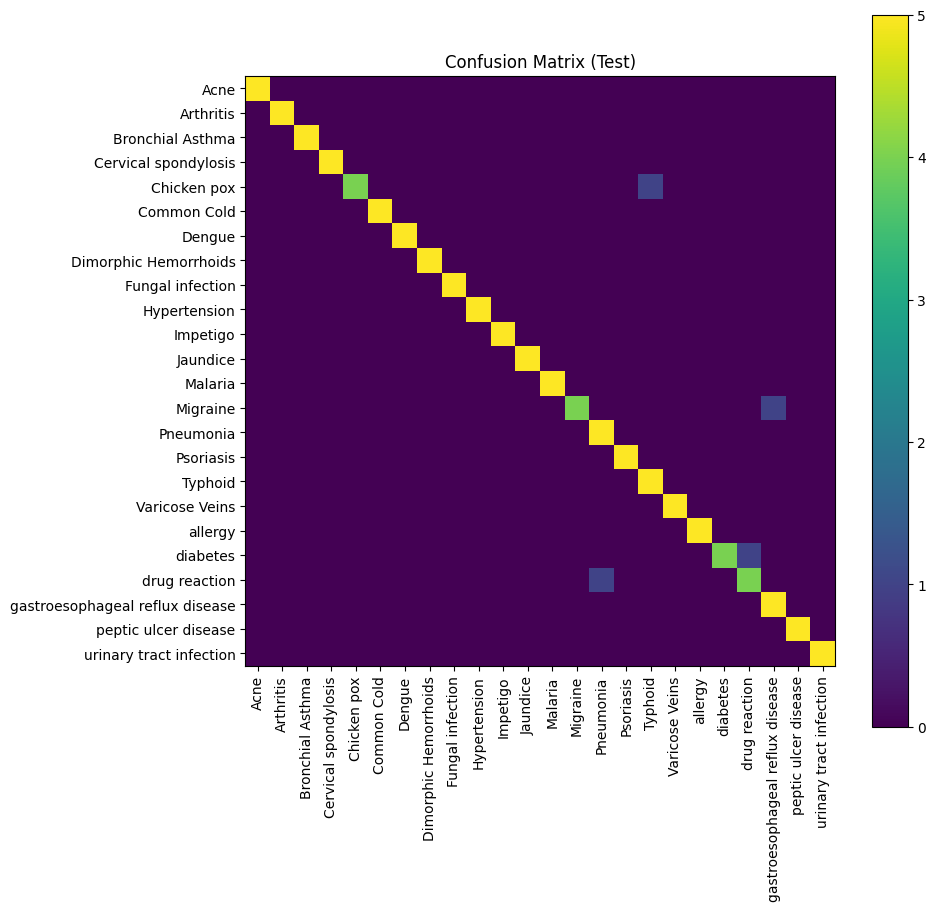

In [ ]:
cm = confusion_matrix(y_test, y_pred_test, labels=best_clf.classes_)
fig = plt.figure(figsize=(10,10))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix (Test)")
plt.xticks(range(len(best_clf.classes_)), best_clf.classes_, rotation=90)
plt.yticks(range(len(best_clf.classes_)), best_clf.classes_)
plt.tight_layout()
plt.colorbar()
plt.show()


In [ ]:
X_trval = pd.concat([train_df['text'], val_df['text']]).values
y_trval = pd.concat([train_df['label'], val_df['label']]).values

final_clf = GridSearchCV(
    pipe, param_grid=param_grid, scoring="f1_macro", cv=cv, n_jobs=-1, verbose=0
).fit(X_trval, y_trval).best_estimator_

# Final test check (optional)
_ = evaluate("Final Test", final_clf, X_test, y_test)

# Save the pipeline for reuse
os.makedirs("artifacts", exist_ok=True)
MODEL_PATH = "artifacts/symptom2disease_tfidf_logreg.joblib"
joblib.dump(final_clf, MODEL_PATH)
print("Saved model to:", MODEL_PATH)



[Final Test]  Accuracy: 0.9750 | Macro-F1: 0.9747

                                 precision    recall  f1-score   support

                           Acne       1.00      1.00      1.00         5
                      Arthritis       1.00      1.00      1.00         5
               Bronchial Asthma       1.00      1.00      1.00         5
           Cervical spondylosis       1.00      1.00      1.00         5
                    Chicken pox       1.00      0.80      0.89         5
                    Common Cold       1.00      1.00      1.00         5
                         Dengue       1.00      1.00      1.00         5
          Dimorphic Hemorrhoids       1.00      1.00      1.00         5
               Fungal infection       1.00      1.00      1.00         5
                   Hypertension       1.00      1.00      1.00         5
                       Impetigo       1.00      1.00      1.00         5
                       Jaundice       1.00      1.00      1.00         

In [ ]:
loaded = joblib.load(MODEL_PATH)
LABELS = list(loaded.classes_)

def predict_topk(text: str, top_k: int = 5):
    """Return sorted top-k diseases with probabilities for a single symptom text."""
    probs = loaded.predict_proba([text])[0]  # shape (num_classes,)
    idx = np.argsort(probs)[::-1]
    top_idx = idx[:top_k]
    return [(LABELS[i], float(probs[i])) for i in top_idx]

def predict_all(text: str):
    """Return all 24 classes sorted by probability (desc)."""
    probs = loaded.predict_proba([text])[0]
    idx = np.argsort(probs)[::-1]
    return [(LABELS[i], float(probs[i])) for i in idx]

# Quick demo
sample = "fever, chills, headache, pain behind the eyes and rashes"
print(predict_topk(sample, top_k=5))


[('Dengue', 0.3878925736821636), ('allergy', 0.06388316404614165), ('Typhoid', 0.05544869500690663), ('Malaria', 0.04622721459593016), ('drug reaction', 0.04341036874344042)]


In [ ]:
def predict_with_threshold(text: str, threshold: float = 0.35, top_k: int = 5):
    ranked = predict_all(text)
    top_label, top_prob = ranked[0]
    if top_prob < threshold:
        top_label = f"Uncertain (top={top_label} @ {top_prob:.2f})"
    return top_label, ranked[:top_k]


In [ ]:
symptoms = w.Textarea(
    value="",
    placeholder="e.g., high fever, severe headache, muscle/joint pain, rash",
    description="Symptoms:",
    layout=w.Layout(width="100%", height="110px")
)
btn_predict = w.Button(description="Predict", button_style="primary")
btn_clear = w.Button(description="Clear")
out = w.Output()

def on_predict(_):
    with out:
        out.clear_output()
        text = (symptoms.value or "").strip()
        if not text:
            display(HTML("<b>Please type symptoms.</b>"))
            return
        ranked = predict_all(text)            # uses your previously defined function
        top_label, top_prob = ranked[0]
        display(HTML(
            f"<h3>Predicted disease: {top_label}</h3>"
            f"<p><b>Probability:</b> {top_prob:.2%}</p>"
            "<p style='color:#666'>Research prototype — not medical advice.</p>"
        ))

def on_clear(_):
    with out:
        out.clear_output()
    symptoms.value = ""

btn_predict.on_click(on_predict)
btn_clear.on_click(on_clear)

display(w.VBox([
    w.HTML("<h2>🩺 Symptom → Disease</h2>"),
    symptoms,
    w.HBox([btn_predict, btn_clear]),
    out
]))

In [ ]:
def score_csv(input_csv_path, output_csv_path, include_all_probs=False):
    data = pd.read_csv(input_csv_path, encoding='utf-8')
    assert 'text' in data.columns, "Input CSV must have a 'text' column."
    probs = loaded.predict_proba(data['text'].fillna("").astype(str).tolist())
    preds = probs.argmax(axis=1)
    data['predicted_label'] = [LABELS[i] for i in preds]
    data['predicted_prob']  = probs.max(axis=1)
    if include_all_probs:
        for i, c in enumerate(LABELS):
            data[f'prob_{c}'] = probs[:, i]
    data.to_csv(output_csv_path, index=False)
    return output_csv_path

# Example:
score_csv('unseen_symptoms.csv', 'scored_symptoms.csv', include_all_probs=True)


FileNotFoundError: [Errno 2] No such file or directory: 'unseen_symptoms.csv'